# SNS process -  Rate Distortion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kl_div
import seaborn as sns
from scipy.special import rel_entr
from CIB import causal_information_bottleneck

In [2]:
def interevent_distribution(n, p, q):
    """
    Calculates the interevent distribution F(n) for the SNS, 
    see Eq. 15 in arxiv.org:1408.6876
    
    Parameters:
    n (int or array): Number of 0's between consecutive 1's
    p, q (float): SNS parameters (transition probabilities)
    
    Returns:
    float or array: F(n) values
    """
    if isinstance(n, np.ndarray):
        result = np.zeros_like(n, dtype=float)
        for i, val in enumerate(n):
            result[i] = interevent_distribution(val, p, q)
        return result
    
    if n < 0:
        print("Error n is less than 0")
        
    if abs(p - q) < 1e-10:  # p = q case
        return (1-p)**2 * n * (p**(n-1))
    else:
        print("p not equal to q error")

def survival_function(n, p, q):
    """
    Calculates the survival function w(n) for the SNS, 
    summing over F(n) and using the geometric series.
    
    Parameters:
    n (int or array): Threshold value
    p, q (float): SNS parameters
    
    Returns:
    float or array: w(n) values
    """
    if isinstance(n, np.ndarray):
        result = np.zeros_like(n, dtype=float)
        for i, val in enumerate(n):
            result[i] = survival_function(val, p, q)
        return result
    
    if n < 0:
        print("Error n is less than 0")
    
    if abs(p - q) < 1e-10:  # p = q case
        return (p**(n-1))*(p + n*(1-p))
    else:  # p ≠ q case
        print("p not equal to q error")

def mean_interevent(p, q):
    """
    Calculates the mean interevent count μ for the SNS,
    summing over w(n) and using the geometric series.
    
    Parameters:
    p, q (float): SNS parameters
    
    Returns:
    float: Mean interevent count
    """
    if abs(p - q) < 1e-10:  # p = q case
        return (1+p)/(1-p)
    else:  # p ≠ q case
        print("p not equal to q error")

def joint_probability(p, q, M):
    """
    Calculate the joint probability distribution p(σ+,σ-) for the SNS,
    see App. B, pg. 15 in arxiv.org:1408.6876. Sum over aggregate states
    where relevant and use the geometric series.
    
    Parameters:
    p, q (float): SNS parameters
    M (int): Finite-time approximation cutoff
    
    Returns:
    numpy.ndarray: Joint probability matrix
    """
    # Calculate joint probability
    joint_prob = np.zeros((M+1, M+1))
    mu = mean_interevent(p, q)
    
    for sigma_plus in range(M+1):
        for sigma_minus in range(M+1):
            if sigma_plus == M and sigma_minus == M:
                # Both are aggregate states
                if abs(p - q) < 1e-10:  # p = q case
                    joint_prob[sigma_plus, sigma_minus] = 2*p**(2*M-1) * (M*(1-p)+p)  /(mu + 1)
                else:  # p ≠ q case
                    print("p not equal to q error")
            elif sigma_plus == M:
                # Forward state is aggregate
                if abs(p - q) < 1e-10:  # p = q case
                    joint_prob[sigma_plus, sigma_minus] = (p**sigma_minus*p**M)*((1-p)/p *(sigma_minus+M)+1) / (mu + 1)
                else:  # p ≠ q case
                    print("p not equal to q error")
            elif sigma_minus == M:
                # Reverse state is aggregate
                if abs(p - q) < 1e-10:  # p = q case
                    joint_prob[sigma_plus, sigma_minus] = (p**sigma_plus*p**M)*((1-p)/p *(sigma_plus+M)+1) / (mu + 1)
                else:  # p ≠ q case
                    print("p not equal to q error")
            else:
                # Regular states
                joint_prob[sigma_plus, sigma_minus] = interevent_distribution(sigma_plus + sigma_minus, p, q) / (mu + 1)
                
    return joint_prob

def forward_probability(p, q, M):
    """
    Calculate the probability distribution p(σ+) for the SNS,
    see App. A, pg. 13 in arxiv.org:1408.6876.
    
    Parameters:
    p, q (float): SNS parameters
    M (int): Finite-time approximation cutoff
    
    Returns:
    numpy.ndarray: Forward probability distribution
    """
    mu = mean_interevent(p, q)
    prob_sigma_plus = np.zeros(M+1)
    
    # Calculate probabilities for states below the cutoff
    for n in range(M+1):
        prob_sigma_plus[n] = survival_function(n, p, q) / (mu + 1)
    
    return prob_sigma_plus

In [3]:
def plot_information_function(rate_values, distortion_values, E, C_mu):
    """
    Plot the information function (code rate vs. distortion).
                        
    Parameters:
    rate_values: Array of rate values (I[R;σ+])
    distortion_values: Array of distortion values (I[σ+;σ-|R])
    E: Excess entropy (I[σ+;σ-])
    C_mu: Statistical complexity (H[σ+])
    """
    import pandas as pd
    
    # Read data from first_data.csv
    csv_data = pd.read_csv('first_data.csv')
    csv_distortion_values = csv_data.iloc[:, 0]
    csv_rate_values = csv_data.iloc[:, 1]
    
    plt.figure(figsize=(10, 6))
    
    # Plot the original data from CSV as a scatter plot in blue
    plt.scatter(csv_distortion_values, csv_rate_values, color='b', label='original')
    
    # Plot the given rate and distortion values in red
    plt.plot(distortion_values, rate_values, 'ro-', label='reproducing')
    
    plt.axhline(y=C_mu, color='k', linestyle='-.', label=r'$C_\mu$')
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=E, color='k', linestyle=':', label=r'$E$')
    plt.xlabel(r'$I[\overset{\leftarrow}{X};\overset{\rightarrow}{X}|R]$')
    plt.ylabel(r'$I[R;\overset{\leftarrow}{X}]$')
    plt.title('Information Function for SNS')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Highlight x=0 and y=0 axes in solid black lines
    plt.axhline(y=0, color='black')
    plt.axvline(x=0, color='black')
    
    plt.tight_layout()
    plt.show()

def plot_feature_curve(feature_curve, C_mu):
    """
    Plot the feature curve (rate vs. beta) and compare with data from a CSV file.
    
    Parameters:
    feature_curve: Array of (beta, rate) pairs
    C_mu: Statistical complexity (H[σ+])
    """
    import pandas as pd
    
    # Extract data from feature_curve
    betas = feature_curve[:, 0]
    rates = feature_curve[:, 1]
    
    # Read data from CSV file
    csv_data = pd.read_csv('second_data.csv')
    csv_betas = csv_data.iloc[:, 0]
    csv_rates = csv_data.iloc[:, 1]
    
    plt.figure(figsize=(10, 6))
    
    # Plot feature_curve data with lines
    plt.semilogx(betas, rates, 'ro-', label='reproducing')
    
    # Plot CSV data as a scatter plot
    plt.scatter(csv_betas, csv_rates, color='b', label='original')
    
    # Plot C_mu line
    plt.axhline(y=C_mu, color='k', linestyle='--', label=r'$C_\mu$')
    
    # Set axis labels with arrows
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$I[R;\overset{\leftarrow}{X}]$')
    
    plt.title('Feature Curve for SNS')
    plt.legend(loc='upper left')
    plt.grid(True)
    
    # Highlight x=0 and y=0 axes in solid black lines
    plt.axhline(y=0, color='black')
    plt.axvline(x=0, color='black')
    
    plt.tight_layout()
    plt.show()

def run_sns_cib_analysis(p, q, M, num_clusters, beta_values,enforce_monotonicity=True, default_restarts=500, default_iter=300, max_restarts=5000, max_iter=500,annealing=False,perturbation_size=0.01):
    """
    Run the CIB analysis on the SNS process and plot the results.
    
    Parameters:
    p, q (float): SNS parameters
    M (int): Finite-time approximation cutoff
    num_clusters (int): Number of clusters to use in the representation
    beta_values: Array of beta values to compute
    enforce_monotonicity: Whether to enforce monotonicity of the information function
    """
    # Calculate joint and marginal distributions
    joint_prob = joint_probability(p=p, q=q, M=M)
    p_sigma_plus = forward_probability(p=p, q=q, M=M)
    
    # Verify that distributions are normalized
    total_joint = np.sum(joint_prob)
    total_sigma_plus = np.sum(p_sigma_plus)
    
    print(f"Joint distribution sum: {total_joint:.10f} (should be close to 1.0)")
    print(f"Forward state distribution sum: {total_sigma_plus:.10f} (should be close to 1.0)")
    
    if not np.isclose(total_joint, 1.0, rtol=1e-5):
        print("WARNING: Joint probability distribution does not sum to 1.0")
        # Normalize to ensure proper distribution
        joint_prob = joint_prob / total_joint
    
    if not np.isclose(total_sigma_plus, 1.0, rtol=1e-5):
        print("WARNING: Forward state probability distribution does not sum to 1.0")
        # Normalize to ensure proper distribution
        p_sigma_plus = p_sigma_plus / total_sigma_plus
    
    # Calculate reverse-time marginal probability
    p_sigma_minus = np.sum(joint_prob, axis=0)
    
    # Calculate excess entropy (mutual information between σ+ and σ-)
    E = 0
    for i in range(M+1):
        for j in range(M+1):
            if joint_prob[i,j] > 0:
                # Using log base 2 for information theory quantities in bits
                ratio = joint_prob[i,j] / (p_sigma_plus[i] * p_sigma_minus[j])
                E += joint_prob[i,j] * np.log2(ratio)
    
    # Add a sanity check
    if E < 0:
        print(f"WARNING: Calculated excess entropy is negative ({E:.6f}), which should not happen.")
        print("Checking for potential numerical issues...")
        
        # Check for numerical issues in the calculation
        min_ratio = float('inf')
        max_ratio = float('-inf')
        for i in range(M+1):
            for j in range(M+1):
                if joint_prob[i,j] > 0:
                    ratio = joint_prob[i,j] / (p_sigma_plus[i] * p_sigma_minus[j])
                    min_ratio = min(min_ratio, ratio)
                    max_ratio = max(max_ratio, ratio)
        
        print(f"Minimum ratio: {min_ratio:.10f}")
        print(f"Maximum ratio: {max_ratio:.10f}")
        
        # Try a more numerically stable calculation
        E_stable = 0
        for i in range(M+1):
            for j in range(M+1):
                if joint_prob[i,j] > 0:
                    # Avoid potential underflow/overflow in the ratio
                    log_joint = np.log2(max(joint_prob[i,j], 1e-100))
                    log_plus = np.log2(max(p_sigma_plus[i], 1e-100))
                    log_minus = np.log2(max(p_sigma_minus[j], 1e-100))
                    E_stable += joint_prob[i,j] * (log_joint - log_plus - log_minus)
        
        print(f"Recalculated excess entropy with more numerical stability: {E_stable:.6f} bits")
        E = max(0, E_stable)  # Ensure non-negative result
    
    # Calculate statistical complexity
    C_mu = -np.sum(p_sigma_plus * np.log2(p_sigma_plus + (p_sigma_plus == 0)))
    
    print(f"Excess Entropy E = {E:.6f} bits")
    print(f"Statistical Complexity C_μ = {C_mu:.6f} bits")
    
    # Run CIB algorithm
    print("Running Causal Information Bottleneck algorithm...")
    rate_values, distortion_values, feature_curve = causal_information_bottleneck(
        joint_prob, p_sigma_plus, beta_values, num_clusters, 
        default_restarts=default_restarts, default_iter=default_iter,
        max_restarts=max_restarts, max_iter=max_iter,
        enforce_monotonicity=enforce_monotonicity,
        convergence_threshold=1e-6,annealing=annealing,perturbation_size=perturbation_size
    )
    
    # Sort results by distortion (for smooth curves)
    idx = np.argsort(distortion_values)
    rate_values = rate_values[idx]
    distortion_values = distortion_values[idx]
    
    # Plot results
    plot_information_function(rate_values, distortion_values, E, C_mu)
    plot_feature_curve(feature_curve, C_mu)
    
    return rate_values, distortion_values, feature_curve, E, C_mu

## results

## [wrongfully divide kl_values by log(2)] Annealing after beta=10^3  with perturbation coefficient 0.1 (scaling with pt_r_given_sigma_plus)

Analyzing SNS process with parameters p=0.5, q=0.5
Using finite-time approximation with M=10 and 10 clusters
Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
M in conditional_probability_minus_given_plus 10
Total mutual information I[σ+;σ-] = 0.149245 bits
###########################################################
[0.0%] Processing β=1.000000
best_objective 6.114051443184921e-17 best_distortion 0.14924496770329818 best_rate 4.2982329626545855e-17
H[σ+] 2.6822582430942674 H[σ+|R] 2.682258243094267
###########################################################
[0.5%] Processing β=1.059560
best_objective 2.8066698303126483e-17 best_distortion 0.14924496770329831 best_rate -6.315797255859958e-17
H[σ+] 2.6822582430942674 H[σ+|R] 2.6822582430942674
#######################################

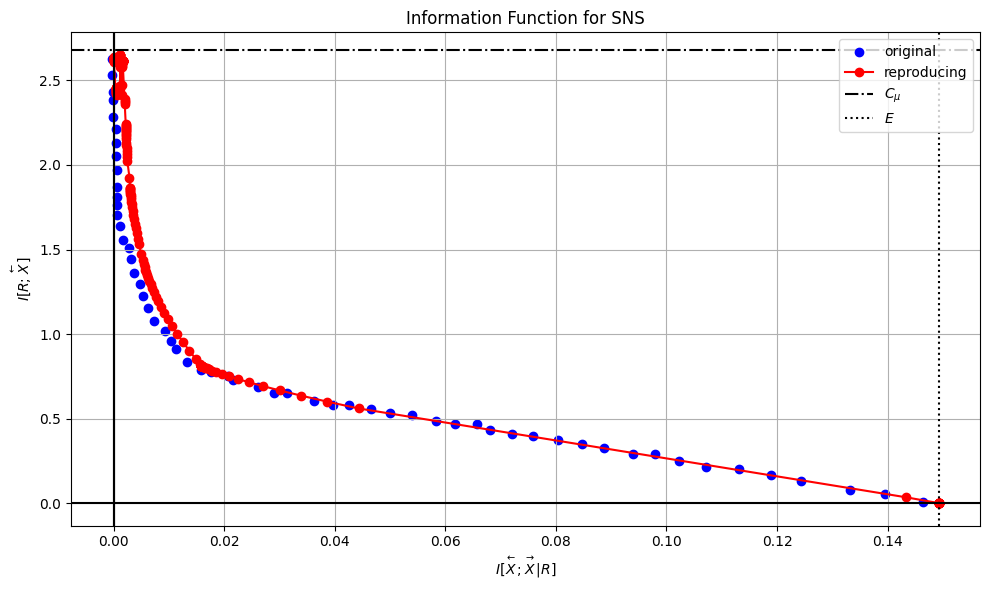

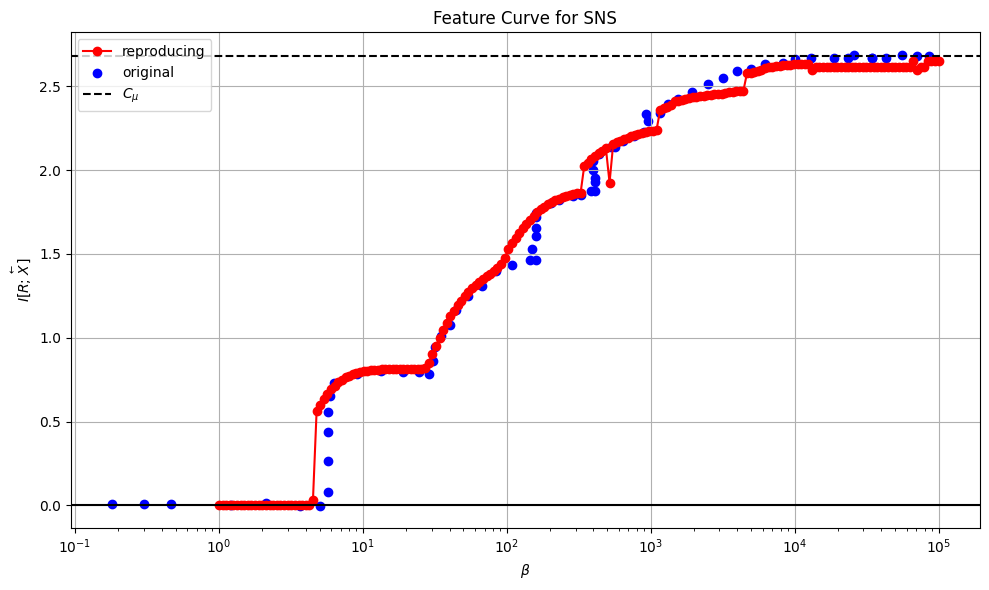

In [4]:
if __name__ == "__main__":
    # Set parameters for the SNS process
    p = 0.5
    q = 0.5
    M=10
    num_clusters = 10
    
    print(f"Analyzing SNS process with parameters p={p}, q={q}")
    print(f"Using finite-time approximation with M={M} and {num_clusters} clusters")
    
    # Run the analysis
    results = run_sns_cib_analysis(p=p, q=q, M=M, num_clusters=num_clusters,beta_values=np.logspace(0, 5, 200),default_restarts=10, default_iter=30, max_restarts=5000, max_iter=500,enforce_monotonicity=False,annealing=True,perturbation_size=0.1)

## No annealing

Analyzing SNS process with parameters p=0.5, q=0.5
Using finite-time approximation with M=10 and 10 clusters
Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
M in conditional_probability_minus_given_plus 10
Total mutual information I[σ+;σ-] = 0.149245 bits
###########################################################
[0.0%] Processing β=1.000000
best_objective 3.784714479092773e-17 best_distortion 0.14924496770329823 best_rate 2.393615776417376e-17
H[σ+] 2.6822582430942674 H[σ+|R] 2.682258243094267
###########################################################
[0.5%] Processing β=1.059560
best_objective 2.58764676588603e-19 best_distortion 0.14924496770329831 best_rate -1.8200877552948798e-17
H[σ+] 2.6822582430942674 H[σ+|R] 2.6822582430942674
#########################################

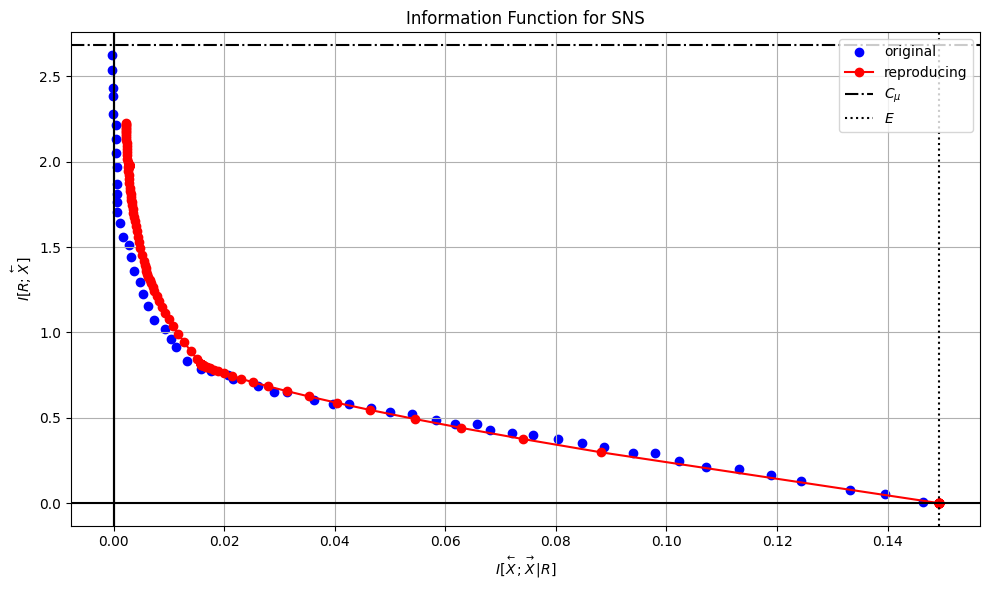

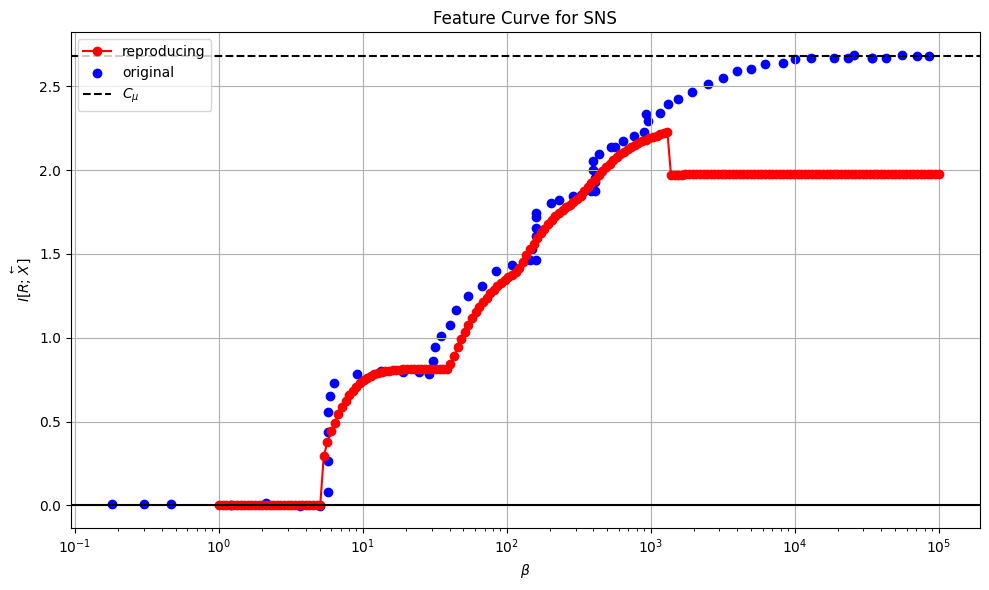

In [6]:
if __name__ == "__main__":
    # Set parameters for the SNS process
    p = 0.5
    q = 0.5
    M=10
    num_clusters = 10
    
    print(f"Analyzing SNS process with parameters p={p}, q={q}")
    print(f"Using finite-time approximation with M={M} and {num_clusters} clusters")
    
    # Run the analysis
    results = run_sns_cib_analysis(p=p, q=q, M=M, num_clusters=num_clusters,beta_values=np.logspace(0, 5, 200),default_restarts=10, default_iter=30, max_restarts=5000, max_iter=500,enforce_monotonicity=False,annealing=False,perturbation_size=0.1)

## Annealing after beta=10^3  with perturbation coefficient 0.1 (scaling with pt_r_given_sigma_plus)

Analyzing SNS process with parameters p=0.5, q=0.5
Using finite-time approximation with M=10 and 10 clusters
Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
M in conditional_probability_minus_given_plus 10
Total mutual information I[σ+;σ-] = 0.149245 bits
###########################################################
[0.0%] Processing β=1.000000
best_objective 3.784714479092773e-17 best_distortion 0.14924496770329823 best_rate 2.393615776417376e-17
H[σ+] 2.6822582430942674 H[σ+|R] 2.682258243094267
###########################################################
[0.5%] Processing β=1.059560
best_objective 2.58764676588603e-19 best_distortion 0.14924496770329831 best_rate -1.8200877552948798e-17
H[σ+] 2.6822582430942674 H[σ+|R] 2.6822582430942674
#########################################

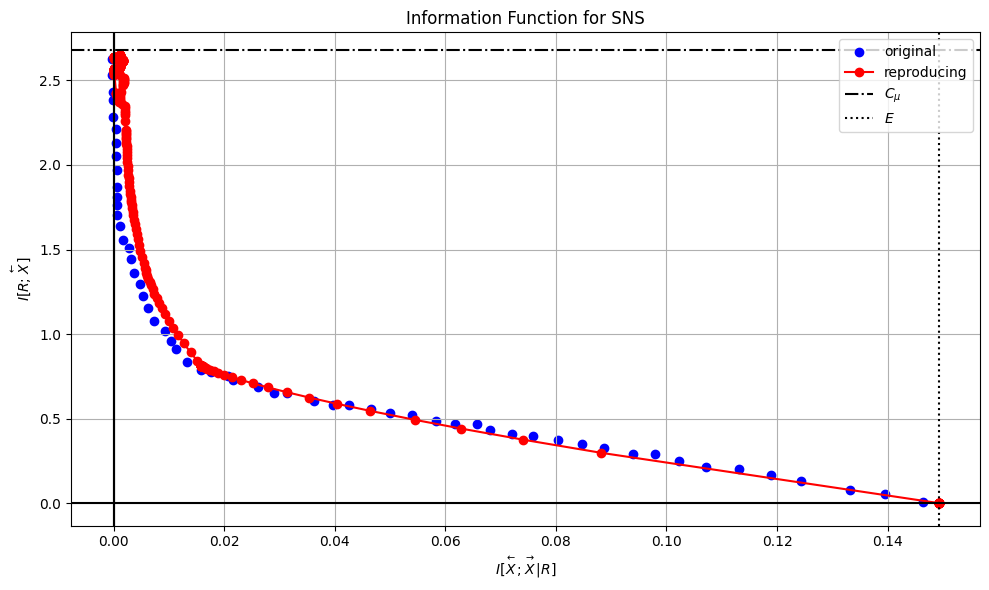

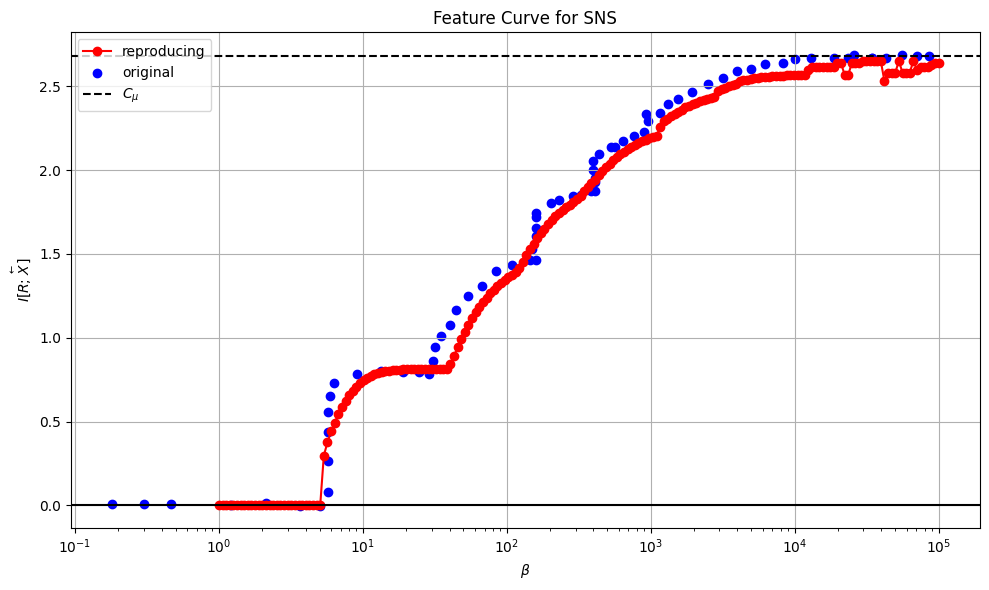

In [5]:
if __name__ == "__main__":
    # Set parameters for the SNS process
    p = 0.5
    q = 0.5
    M=10
    num_clusters = 10
    
    print(f"Analyzing SNS process with parameters p={p}, q={q}")
    print(f"Using finite-time approximation with M={M} and {num_clusters} clusters")
    
    # Run the analysis
    results = run_sns_cib_analysis(p=p, q=q, M=M, num_clusters=num_clusters,beta_values=np.logspace(0, 5, 200),default_restarts=10, default_iter=30, max_restarts=5000, max_iter=500,enforce_monotonicity=False,annealing=True,perturbation_size=0.1)